$s$

In [1]:
import ipywidgets as widgets
out = widgets.Output()
with out:
    
    %bookmark 'model_dir'
    current_dir = %pwd
    while 'models' in current_dir:
        %cd ..
        current_dir = %pwd
    %bookmark 'base_dir'
    %cd source_code
    out.clear_output()
%run base
%run gui_v6
with out:
    %cd ..
    %cd models/fourbar
    out.clear_output()


In [2]:
m=model()
m.show()

## VEHICLE DYNAMICS MODELING AND SIMULATION TOOL

In [4]:
m.model_tree()

In [44]:
m.topology.remove_edge(m.bodies['rbs_ground'],m.bodies['rbs_crank'],1)

In [3]:
m.actuators

mcs_rot    <constraints.rotational_actuator object at 0x0...
dtype: object

In [4]:

m.topology.edges

OutMultiEdgeView([(rbs_ground, rbs_crank, 0), (rbs_ground, rbs_crank, 1), (rbs_crank, rbs_conn, 0), (rbs_conn, rbs_slider, 0), (rbs_slider, rbs_ground, 0)])

In [5]:
m.topology.nodes

NodeView((rbs_ground, rbs_crank, rbs_conn, rbs_slider))

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 12 20:41:13 2018

@author: khale
"""


import numpy as np
import scipy as sc

def jacobian_creator(topology):
    
    edgelist = topology.edges(data='joint')
    nodelist = topology.nodes
    
    n_nodes = len(nodelist)
    n_edges = len(edgelist)
            
    jacobian = np.zeros((n_edges+n_nodes,n_nodes),dtype=np.object)
    jacobian.fill(None)
    
    equations = np.zeros((n_edges+n_nodes,1),dtype=np.object)
    
    vel_rhs = np.zeros((n_edges+n_nodes,1),dtype=np.object)
    acc_rhs = np.zeros((n_edges+n_nodes,1),dtype=np.object)
    
    node_index = dict( (node,i) for i,node in enumerate(nodelist) )
        
    for ei,e in enumerate(edgelist):
        (u,v) = e[:2]
        eo    = e[2]
        
        ui = node_index[u]
        vi = node_index[v]
        
        if jacobian[ui+n_edges,ui]==None: jacobian[ui+n_edges,ui] = (u.jac,ui)
        if jacobian[vi+n_edges,vi]==None: jacobian[vi+n_edges,vi] = (v.jac,vi)
                
        jacobian[ei,ui] = (eo.jacobian_i,ui,vi)
        jacobian[ei,vi] = (eo.jacobian_j,ui,vi)
        
        equations[ei,0] = (eo.equations,ui,vi)
        if equations[ui+n_edges,0]==0: equations[ui+n_edges,0]=(u.equations,ui)
        if equations[vi+n_edges,0]==0: equations[vi+n_edges,0]=(v.equations,vi)
        
        
        vel_rhs[ei,0] = ((eo.vel_rhs) if eo.nc==1 else np.zeros((eo.nc,1)))
        vel_rhs[ui+n_edges,0] = (np.array([[0]]) if u.nc==1 else np.zeros((7,1)))
        vel_rhs[vi+n_edges,0] = (np.array([[0]]) if v.nc==1 else np.zeros((7,1)))
        
        acc_rhs[ei,0] = (eo.acc_rhs,ui,vi)
        if acc_rhs[ui+n_edges,0]==0: acc_rhs[ui+n_edges,0]=(u.acc_rhs,ui)
        if acc_rhs[vi+n_edges,0]==0: acc_rhs[vi+n_edges,0]=(v.acc_rhs,vi)
        
      
    def j_mapper(i,q):
        if len(i)==3:
            fun,bi,bj = i
            return fun(q[bi],q[bj])
        else:
            fun,bi = i
            return fun(q[bi])
        

    vectorized_j = np.vectorize(j_mapper,otypes=[np.object],excluded='q')
    
    
    def v_mapper(i):
        try:
            if i.all()==0:
                return i
        except AttributeError:
            return i()

    vectorized_v = np.vectorize(v_mapper,otypes=[np.object])
    
    def a_mapper(i,q,qd):
        if len(i)==3:
            fun,bi,bj = i
            return fun(q[bi],q[bj],qd[bi],qd[bj])
        else:
            fun,bi = i
            return fun(qd[bi])

    vectorized_a = np.vectorize(a_mapper,otypes=[np.object],excluded=('q','qd'))
    
    return jacobian, equations, vel_rhs, acc_rhs, jacobian.nonzero(), vectorized_j, vectorized_v, vectorized_a


def jacobian_evaluator(jac_blocks,nzi,mapper,q):
    A = jac_blocks.copy()
    A[nzi]=mapper(A[nzi],q=q)
    return sc.sparse.bmat(A,format='csc')


In [7]:
def nr_kds(j,e,nzi,mapper,q):
    
    A = jacobian_evaluator(j,nzi,mapper,q.values.reshape((2,7)))
    
    b = e.copy()
    b = np.concatenate(mapper(e[e.nonzero()],q=q.values.reshape((2,7))))
    delta_q = sc.sparse.linalg.spsolve(A,-b)
    
    itr=0
    while np.linalg.norm(delta_q)>1e-5:
        
        q=q+delta_q
        
        if itr!=0 and itr%5==0:
            print('Recalculating Jacobian')
            A = jacobian_evaluator(j,nzi,mapper,q.values.reshape((2,7)))
        b = np.concatenate(mapper(e[e.nonzero()],q=q.values.reshape((2,7))))
        delta_q = sc.sparse.linalg.spsolve(A,-b)
        
        itr+=1
        


        if itr>200:
            print("Iterations exceded \n")
            break    
    
    return q,A


def kds(topology,actuators,time_array):
    q0 = pd.concat([i.q0 for i in topology.nodes])
    j,e,v,a,nzi,j_m, v_m, a_m = jacobian_creator(topology)
    
    position_df=pd.DataFrame(columns=q0.index)
    position_df.loc[0]=q0
    
    A = jacobian_evaluator(j,nzi,j_m,q0.values.reshape((2,7)))
     
    velocity_df=pd.DataFrame(columns=q0.index)
    velocity_df.loc[0]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(v_m(v)[:,0]))
        
    acceleration_df=pd.DataFrame(columns=q0.index)
    acceleration_df.loc[0]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(a_m(a,q=q0.values.reshape((2,7)),qd=velocity_df.loc[0].values.reshape((2,7)))[:,0]))
    
    
    print('\nRunning System Kinematic Analysis:')
    dt = time_array[1]-time_array[0]
    for i,step in enumerate(time_array):
        #print(i)
        
        for ac in actuators:
            ac.t=step
        
        
        g=position_df.loc[i]+velocity_df.loc[i]*dt + 0.5*acceleration_df.loc[i]*dt**2
         
        position_df.loc[i+1],A=nr_kds(j,e,nzi,j_m,g)
        qi=position_df.loc[i+1]
        velocity_df.loc[i+1]=vi=sc.sparse.linalg.spsolve(A,-1*np.concatenate(v_m(v)[:,0]))
        acceleration_df.loc[i+1]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(a_m(a,q=qi.values.reshape((2,7)),qd=vi.reshape((2,7)))[:,0]))
          
        i+=1
        
    return position_df, velocity_df, acceleration_df
    

In [9]:
def nr_kds(j,e,nzi,mapper,q):
    
    A = jacobian_evaluator(j,nzi,mapper,q.values.reshape((4,7)))
    
    b = e.copy()
    b = np.concatenate(mapper(e[e.nonzero()],q=q.values.reshape((4,7))))
    delta_q = sc.sparse.linalg.spsolve(A,-b)
    
    itr=0
    while np.linalg.norm(delta_q)>1e-5:
        
        q=q+delta_q
        
        if itr!=0 and itr%5==0:
            print('Recalculating Jacobian')
            A = jacobian_evaluator(j,nzi,mapper,q.values.reshape((4,7)))
        b = np.concatenate(mapper(e[e.nonzero()],q=q.values.reshape((4,7))))
        delta_q = sc.sparse.linalg.spsolve(A,-b)
        
        itr+=1
        


        if itr>200:
            print("Iterations exceded \n")
            break    
    
    return q,A


def kds(topology,actuators,time_array):
    q0 = pd.concat([i.q0 for i in topology.nodes])
    j,e,v,a,nzi,j_m, v_m, a_m = jacobian_creator(topology)
    
    position_df=pd.DataFrame(columns=q0.index)
    position_df.loc[0]=q0
    
    A = jacobian_evaluator(j,nzi,j_m,q0.values.reshape((4,7)))
     
    velocity_df=pd.DataFrame(columns=q0.index)
    velocity_df.loc[0]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(v_m(v)[:,0]))
        
    acceleration_df=pd.DataFrame(columns=q0.index)
    acceleration_df.loc[0]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(a_m(a,q=q0.values.reshape((4,7)),qd=velocity_df.loc[0].values.reshape((4,7)))[:,0]))
    
    
    print('\nRunning System Kinematic Analysis:')
    dt = time_array[1]-time_array[0]
    for i,step in enumerate(time_array):
        #print(i)
        
        for ac in actuators:
            ac.t=step
        
        
        g=position_df.loc[i]+velocity_df.loc[i]*dt + 0.5*acceleration_df.loc[i]*dt**2
         
        position_df.loc[i+1],A=nr_kds(j,e,nzi,j_m,g)
        qi=position_df.loc[i+1]
        velocity_df.loc[i+1]=vi=sc.sparse.linalg.spsolve(A,-1*np.concatenate(v_m(v)[:,0]))
        acceleration_df.loc[i+1]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(a_m(a,q=qi.values.reshape((4,7)),qd=vi.reshape((4,7)))[:,0]))
          
        i+=1
        
    return position_df, velocity_df, acceleration_df
    

In [10]:
q0=pd.concat([i.q0 for i in m.topology.nodes])

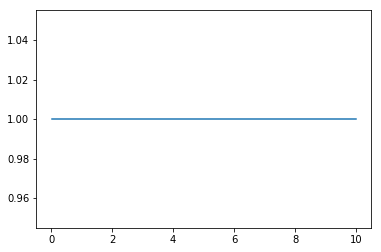

In [12]:
t_a = np.linspace(10/500,10,500)
pos=[]
vel=[]
acc=[]
for i in t_a:
    m.actuators[0].t=i
    pos.append(m.actuators[0].pos)
    vel.append(m.actuators[0].vel)
    acc.append(m.actuators[0].acc)
plt.plot(t_a,vel)
plt.show()

In [13]:
j,e,v,a,nzi,mapper_j,mapper_v, mapper_a = jacobian_creator(m.topology)

In [14]:
t_a = np.linspace(10/500,10,500)
qs,qv,qa = kds(m.topology,m.actuators,t_a)


Running System Kinematic Analysis:


In [15]:
def f(i):
    plt.figure(figsize=(8,8))
    #plt.plot(t_a[0:i],qs['rbs_crank.x'][0:i])
    plt.plot(qs['rbs_crank.x'][0:i],qs['rbs_slider.x'][0:i])
    #plt.xlim(0,10)
    plt.xlim(-40,40)
    plt.ylim(75,240)
    plt.grid()
    plt.show()
widgets.interact(f,i=widgets.IntSlider(value=1,max=500,min=1))


interactive(children=(IntSlider(value=1, description='i', max=500, min=1), Output()), _dom_classes=('widget-in…

<function __main__.f>

In [15]:
def f(i):
    plt.figure(figsize=(8,8))
    plt.plot(t_a[0:i],qa['rbs_link.z'][0:i])
    plt.plot(t_a[0:i],qa['rbs_link.x'][0:i])
    plt.xlim(0,10)
    plt.grid()
    plt.show()
widgets.interact(f,i=(0,500))


interactive(children=(IntSlider(value=250, description='i', max=500), Output()), _dom_classes=('widget-interac…

<function __main__.f>

In [50]:
def f(i):
    plt.figure(figsize=(8,8))
    plt.plot(qs['rbs_link.x'][0:i],qs['rbs_link.z'][0:i])
    plt.xlim(-1500,1500)
    plt.ylim(-1500,1500)
    plt.grid()
    plt.show()
widgets.interact(f,i=(0,500))

interactive(children=(IntSlider(value=250, description='i', max=500), Output()), _dom_classes=('widget-interac…

<function __main__.f>

In [36]:
def f(i):
    plt.plot(t_a[0:i],qv['rbs_link.z'][0:i])
    plt.plot(t_a[0:i],qv['rbs_link.x'][0:i])
    plt.show()
widgets.interact(f,i=(0,500))

interactive(children=(IntSlider(value=250, description='i', max=500), Output()), _dom_classes=('widget-interac…

<function __main__.f>

In [157]:
%timeit jacobian_evaluator(j,nzi,mapper,q0.values.reshape(4,7))

7.62 ms ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
ib = m.actuators[0].i_body.q0
jb = m.actuators[0].j_body.q0
m.actuators[0].equations(ib,jb)
m.actuators[0].pos

10.0

In [18]:
q_ground, q_link = q0.values.reshape((2,7))
rev = m.joints['jcs_rev']
rev.jacobian_j(q_ground,q_link).A

array([[ -1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -5.41196100e+02,   1.30656296e+03,  -5.41196100e+02,
          1.30656296e+03],
       [  0.00000000e+00,  -1.00000000e+00,   0.00000000e+00,
         -1.30656296e+03,   5.41196100e+02,   1.30656296e+03,
         -5.41196100e+02],
       [  0.00000000e+00,   0.00000000e+00,  -1.00000000e+00,
         -5.41196100e+02,  -1.30656296e+03,   5.41196100e+02,
          1.30656296e+03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.84775907e+00,  -1.02812316e-16,  -3.44394088e-16,
          7.65366865e-01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.45682066e-16,   7.65366865e-01,   1.84775907e+00,
         -1.02812316e-16]])

In [19]:
j

array([[ (<bound method revolute.jacobian_i of <constraints.revolute object at 0x0000023EEEBA8BA8>>, 0, 1),
        (<bound method revolute.jacobian_j of <constraints.revolute object at 0x0000023EEEBA8BA8>>, 0, 1)],
       [ (<bound method rotational_actuator.jacobian_i of <constraints.rotational_actuator object at 0x0000023EE75F0F28>>, 0, 1),
        (<bound method rotational_actuator.jacobian_j of <constraints.rotational_actuator object at 0x0000023EE75F0F28>>, 0, 1)],
       [(<bound method mount.jac of rbs_ground>, 0), None],
       [None, (<bound method rigid.jac of rbs_link>, 1)]], dtype=object)

In [20]:
jn = jacobian_evaluator(j,nzi,mapper_j,q=q0.values.reshape((2,7))).A
np.argmax(abs(np.linalg.inv(jn)))
abs(jn-np.array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -5.41196100e+02,   1.30656296e+03,
         -5.41196100e+02,   1.30656296e+03],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,  -1.00000000e+00,
          0.00000000e+00,  -1.30656296e+03,   5.41196100e+02,
          1.30656296e+03,  -5.41196100e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -1.00000000e+00,  -5.41196100e+02,  -1.30656296e+03,
          5.41196100e+02,   1.30656296e+03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.92523114e-17,   1.41421356e+00,   1.96261557e-16,
          1.41421356e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.84775906e+00,  -1.66533454e-16,
         -3.33066907e-16,   7.65366862e-01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.96261557e-16,   1.41421356e+00,  -3.92523114e-17,
         -1.41421356e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.33066907e-16,   7.65366862e-01,
          1.84775906e+00,   1.66533454e-16],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.67803194e-09,   7.85046228e-17,  -1.99999999e+00,
         -7.85046228e-17,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   5.41196098e-01,   1.30656296e+00,
         -5.41196099e-01,  -1.30656296e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -5.41196100e-01,   1.30656296e+00,
         -5.41196100e-01,   1.30656296e+00]]))<1e-5

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         

In [21]:
jn

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -5.41196100e+02,   1.30656296e+03,
         -5.41196100e+02,   1.30656296e+03],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,  -1.00000000e+00,
          0.00000000e+00,  -1.30656296e+03,   5.41196100e+02,
          1.30656296e+03,  -5.41196100e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -1.00000000e+00,  -5.41196100e+02,  -1.30656296e+03,
          5.41196100e+02,   1.30656296e+03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.24491566e-16,   1.41421356e+00,   1.89526925e-1

In [26]:
rev.jacobian_i(q_ground,q_link).A

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.24491566e-16,   1.41421356e+00,   1.89526925e-16,
          1.41421356e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.89526925e-16,   1.41421356e+00,  -1.24491566e-16,
         -1.41421356e+00]])

In [27]:
rev.jacobian_j(q_ground,q_link).A

array([[ -1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -5.41196100e+02,   1.30656296e+03,  -5.41196100e+02,
          1.30656296e+03],
       [  0.00000000e+00,  -1.00000000e+00,   0.00000000e+00,
         -1.30656296e+03,   5.41196100e+02,   1.30656296e+03,
         -5.41196100e+02],
       [  0.00000000e+00,   0.00000000e+00,  -1.00000000e+00,
         -5.41196100e+02,  -1.30656296e+03,   5.41196100e+02,
          1.30656296e+03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.84775907e+00,  -1.02812316e-16,  -3.44394088e-16,
          7.65366865e-01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.45682066e-16,   7.65366865e-01,   1.84775907e+00,
         -1.02812316e-16]])

In [22]:
m.actuators[0].jacobian_i(q_ground,q_link).A

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.23796137e-16,   5.55111512e-17,  -2.00000000e+00,
         -5.55111512e-17]])

In [21]:
m.actuators[0].vi_i

[[ 0.70710678]
 [ 0.        ]
 [-0.70710678]]